*Python Machine Learning 2nd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2017

Code Repository: https://github.com/rasbt/python-machine-learning-book-2nd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/LICENSE.txt)

Prepared by JH Lee

# Chapter 15 - Classifying Images with Deep Convolutional Neural Networks


In this chapter, we'll learn about __Convolutional Neural Networks (CNNs)__ and how to implement CNNs in TensorFlow (TF).

* Understanding convolution operations in one and two dimensions
* Learning about the building blocks of CNN architectures
* Implementing deep CNNs in TF



### Overview

- [Building blocks of convolutional neural networks](#Building-blocks-of-convolutional-neural-networks)
  - [Understanding CNNs and learning feature hierarchies](#Understanding-CNNs-and-learning-feature-hierarchies)
  - [Performing discrete convolutions](#Performing-discrete-convolutions)
    - [Performing a discrete convolution in one dimension](#Performing-a-discrete-convolution-in-one-dimension)
    - [The effect of zero-padding in convolution](#The-effect-of-zero-padding-in-convolution)
    - [Determining the size of the convolution output](#Determining-the-size-of-the-convolution-output)
    - [Performing a discrete convolution in 2D](#Performing-a-discrete-convolution-in-2D)
    - [Sub-sampling](#Sub-sampling)
  - [Putting everything together to build a CNN](#Putting-everything-together-to-build-a-CNN)
    - [The multilayer CNN architecture](#The-multilayer-CNN-architecture)
    - [Loading and preprocessing the data](#Loading-and-preprocessing-the-data)
    - [Implementing a CNN in TensorFlow low-level API](#Implementing-a-CNN-in-TensorFlow-low-level-API)
    - [Implementing a CNN in the TensorFlow layers API](#Implementing-a-CNN-in-the-TensorFlow-layers-API)

In [7]:
from IPython.display import Image
%matplotlib inline

In [9]:
from pil import Image

ModuleNotFoundError: No module named 'pil'

In [2]:
# This is for Python 2.7 compatibility
from __future__ import print_function

# Building blocks of convolutional neural networks 


Convolutional neural networks, or (CNNs) are a family of models that were inspired by how the visual cortex of human brain works when recognizing objects.
* Yann LeCun and his colleagues propoesd a novel neural network architecture for classifying handwritten digits from images (Handwritten Digit Recognition with a Back-Propagation Network, Y LeCun, and others, 1989, published at Neural Information Processing Systems.(NIPS) conference).


## Understanding CNNs and learning feature hierarchies

Successfully extracting __salient (relevant) features__ is key to the performance of any machine learning algorithm.
* traditional machine learning models rely on input features that may come from a domain expert, or are based on computational feature extraction techniques
* neural networks are able to automatically learn the features from raw data that are most useful for a particular task
    * for this reason, it's common to consider a neural network as a feature extraction engine: the early layers (those right after the input layer) extract __low-level features__ (e.g., edges and blobs) 
    * high-level features (e.g., object shapes like a building, a car, or a dog)
* multilayer neural networks and deep CNNs construct a so-called __feature hierarchy__ by combining the low-level features in a layer-wise fashion to form high-level features

A CNN computes __feature maps__ from an input image, where each element comes from a local patch of pixels in the input image:

<img src='images/15_01.png' width=700> 

This local patch of pixels is referred to as the __local receptive field__. 

CNNs will usually perform very well for image-related tasks largely due to two important ideas:
* __Sparse-connectivity__: a single element in the feature map is connected to only a small patch of pixels (cf. connecting to the whole input image)
* __Parmeter-sharing__: the same weights are used for different patches of the input image

The number of weights (parameters) in the network decreases dramatically and ability to capture __salient__ feaures is improved. 

Typically, CNNs are composed of several __Convolutional (conv)__ layers and subsampling (a.k.a. __Pooling (P)__) layers that are followed by one or more __Fully Connected (FC)__ layers at the end.
* there is no weights or bias in the pooling layers, however, both convolution and fully connected layers have weights and biases



## Performing discrete convolutions  

A __discrete convolution__ (or simply __convolution__) is a fundamental operation in a CNN.
* in this section, the mathematical definition and discuss some of the __naive__ algorithms to compute convolutions of two one-dimensional vectors or two two-dimensional matrices



###  Performing a discrete convolution in one dimension

A discrete convolution is defined as follows:

$$ \mathbf{y} = \mathbf{x} * \mathbf{w} \longrightarrow y[i] = \sum^{+\infty}_{k = -\infty} x[i-k] w[k] $$

In practical situations, the bounded feature vector $\mathbf{x}$ is padded with a finite number of zeros, which is called a __zero-padding__ or simply __padding__.

The number of zeros padded on each side is denoted by $p$. 
e.g.,
<img src='images/15_02.png' width=700>

Let's assume that the original input $\mathbf{x}$ and filter $\mathbf{w}$ have $n$ and $m$ elements, respectively, where $m \le n$. Thus, the padded vector $\mathbf{x}^p$ has size $n+2p$. 

The practical formula for computing a discrete convolution will change to the following:

$$ \mathbf{y} = \mathbf{x} * \mathbf{w} \longrightarrow y[i] = \sum^{k=m-1}_{k=0} x^p [i+m-k] w[k] $$

Let's assume we flip the filter $\mathbf{w}$ to get the rotated filter $\mathbf{w}^r$. Then, the dot product $\mathbf{x}[i:i+m] \cdot \mathbf{w}^r$ is computed to get one element $\mathbf{y}[i]$, where $\mathbf{x} [i:i+m]$ is a patch of $\mathbf{x}$ with size $m$.

This operation is repeated like in a sliding window approach to get all the output elements, as exemplified below:

<img src='images/15_03.png' width=700> 
* padding size is zero ($p=0$)
* __shift__ of the rotated filter $\mathbf{w}^r$ is another hyperparameter of a convolution, the __stride__ $s$ (e.g., $s = 2$ in this example)



### The effect of zero-padding in a convolution

Depending on the choice of $p$, boundary cells may be treated differently than the cells located in the middle of $\mathbf{x}$.
e.g., an example where $n = 5, m = 3$. Then, $p = 0$, $\mathbf{x}[0]$ is only used in computing one output element (i.e., y[0]), whereas $\mathbf{x}[1]$ is used in the computation of two output elements (i.e., y[0] and y[1]).
* put more emphsis on x[2] than x[1] 

The size of the output $\mathbf{y}$ also depends on the choice of the padding strategy we use. 

Three modes of padding that are commonly used in practice: __full__, __same__, and __valid__
* in the __full__ mode, $p = m - 1$. increased the dimension of the output, and thus rarely used in CNN architecture
* in the __same__ padding, the size of the output is the same as the size of the input vector $\mathbf{x}$
* in the __valid__ mode, $p = 0$ (no padding)

In the following figure, the three different padding modes were examplified for a simple $5 \times 5$ pixel input with a kernel size of $3 \times 3$ and a stride of 1:

<img src='images/15_11.png' width=700> 
* __same__ padding is commonly used in CNN since the height and width of the input images or tensors are preserved and designing a network architecture more convenient
* __full__ padding is usually used in signal processing applications where it is important to minimize boundary effects, however, in deep learning context, bounday effect is not usually an issue, so full padding is rarely seen




### Determining the size of the convolution output

The output of a convolution is determined by the total number of times that we shift the filter $\mathbf{w}$ along the input vector. The size of the output resulting from $\mathbf{x} * \mathbf{w}$ with padding $p$ and stride $s$ is determined as follows:

$$ o = \left\lfloor \frac{n + 2p - m}{s} + 1 \right\rfloor, $$
where $\lfloor \cdot \rfloor$ denotes the floor operation.


Finally, a naive implementation is shown in the following code block, and the results are compared with the `numpy.convolve` function.


In [3]:
import numpy as np


def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int(len(x)/s),s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]
print('Conv1d Implementation: ', 
      conv1d(x, w, p=2, s=1))
print('Numpy Results:         ', 
      np.convolve(x, w, mode='same'))



Conv1d Implementation:  [  5.  14.  16.  26.  24.  34.  19.  22.]
Numpy Results:          [ 5 14 16 26 24 34 19 22]


### Performing a discrete convolution in 2D

The concepts in the previous sections are easily extendible to two dimensions.

When we deal with 2D input, such as a matrix $\mathbf{X}_{n_1 \times n_2}$ and the filter matrix $\mathbf{W}_{m_1 \times m_2}$, where $m_1 \le n_1$ and $m_2 \le n_2$, then the matrix $\mathbf{Y} = \mathbf{X} * \mathbf{W}$ is the result of 2D convolution of $\mathbf{X}$ with $\mathbf{W}$ defined as follows:

$$ \mathbf{Y} = \mathbf{X} * \mathbf{W} \longrightarrow \mathbf{Y}[i,j] = \sum^{+\infty}_{k_1=-\infty} \sum^{+\infty}_{k_2=-\infty} \mathbf{X}[i-k_1, j-k_2] \mathbf{W}[k_1, k_2] $$

The following example illustrates the computation of a 2D convolution between an input matrix $\mathbf{X}_{3\times3}$, a kernel matrix $\mathbf{W}_{3\times3}$, a padding $p=(1,1)$, and stride $s=(2,2)$.

First, the zero padded matrix $\mathbf{X}^{padded}_{5\times5}$:

<img src='images/15_04.png' width=500> 

The rotated filter will be:

$$ \mathbf{W}^r = \begin{bmatrix} 0.5 & 1 & 0.5 \\ 0.1 & 0.4 & 0.3 \\ 0.4 & 0.7 & 0.5 \end{bmatrix} $$

Next, shifting the rotated filter matrix along the padded input matrix $\mathbf{X}^{padded}$ like a sliding window and compute the sum of the element-wise product ($\odot$):

<img src='images/15_05.png' width=700> 

Let's implement 2D convolution according to the naive algorithm described. 

The `scipy.signal` package provides a way to compute 2D convolution via the `scipy.signal.convolve2d` function:
 

In [4]:
import numpy as np
import scipy.signal


def conv2d(X, W, p=(0,0), s=(1,1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1,n2))
    X_padded[p[0]:p[0] + X_orig.shape[0], 
             p[1]:p[1] + X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0], j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))
    
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1 , 2,0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]
print('Conv2d Implementation: \n', 
      conv2d(X, W, p=(1,1), s=(1,1)))

print('Scipy Results:         \n', 
      scipy.signal.convolve2d(X, W, mode='same'))



Conv2d Implementation: 
 [[ 11.  25.  32.  13.]
 [ 19.  25.  24.  13.]
 [ 13.  28.  25.  17.]
 [ 11.  17.  14.   9.]]
Scipy Results:         
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Subsampling

Subsampling is typically applied in two forms of pooling operations in CNNs: __max-pooling__ and __mean-pooling__ (a.k.a. __average-pooling__).

The pooling layer is usually denoted by $\mathbf{P}_{n_1 \times n_2}$, where the subscript determines the size of the neighborhood that the max or mean operation is performed (i.e., __pooling size__).

The operation is described in the following figure:

<img src='images/15_06.png' width=500> 

The advantage of pooling is twofold:
* introduces some sort of local invariance
    * small changes in a local neighborhood do not change the result of max-pooling
    * helps to generate features more robust to noise in the input data
    <img src='images/15_X1X2.png' width=500>
* decrease the size of features
    * results in higher computational efficiency
    * reduce the number of features and may reduce the degree of overfitting as well



# Putting everything together to build a CNN 


## Working with multiple input or color channels


An input sample to a convolutional layer may contain one or more 2D arrays or matrices with dimensions $N_1 \times N_2$ (e.g., the image height and width in pixels).

These $N_1 \times N_2$ matrices are called __channels__. Therefore, rank-3 tensors or 3D array, $\mathbf{X}_{N_1 \times N_2 \times C_{in}}$, where $C_{in}$ is the number of input channels, is required as input to convolutional layer (e.g., $C_{in} = 3$ for color image, $C_{in} = 1$ for grayscale image).

The convolution operation is performed for each channel separately and then add the results together using the matrix summation.

The total pre-activation result is computed in the following formula:

<img src='images/15_FM_Cin.png' width=500>
* the final result, $\mathbf{h}$ is called a __feature map__

If we use multiple feature maps, the kernel tensor becomes 4D: $width \times height \times C_{in} \times C_{out}$.

Now, let's include the number of output feature maps:

<img src='images/15_FM_CinCout.png' width=500>

To conclude our discussion of computing convolutions in the context of neural networks, let's look at the example in the following figure that shows a convolutional layer followed by a pooling layer:

<img src='images/15_07.png' width=800> 

* three input channels
* kernel tensor is 4D ($m_1 \times m_2$ for each kernel), and there are three of them, one for each input channel
* five such kernels, accounting for five output feature maps
* finally, a polling layer for subsampling the feature maps

Q: how many trainable parameters?


## Regularizing a neural network with dropout

The __capacity__ of a network refer to the level of complexity of the function that can be learned.
* small networks with a relatively small number of parameters, have a low capacity and are therefore likely to be __underfit__
* very large networks may more easily result in __overfitting__
    * memorize the training data and do extremely well on the training set while achieving poor performance on the held-out test set
    
One way to address this problem is to build a network with a relatively large capacity (in practice, that is slightly larger than necessary) to do well on the training set
* then, one or multiple regularization schemes to achieve good generalization performance on new data such as the held-out test set (e.g., L2 regularization) 

In recent years, another popular regularization technique called __dropout__ has emerged.
* intuitively, dropout can be considered as the consensus (averaging) of an ensemble of models 
* usually applied to the hidden units of higher layers
* during the training phase of a neural network, a fraction of the hidden units is __randomly__ dropped at every iteration with probability $p_{drop}$ (or the keep probability $p_{keep} = 1 - p_{drop}$)
    * when dropping a certain fraction of input neurons, the weights associated with the remaining neurons are rescaled to account for the missing (dropped) neurons
    * the network cannot rely on an activation of any set of hidden units since they may be turned off at any time during trianing and is forced to learn more general and robust patterns from the data
 
<img src='images/15_08.png' width=800> 
* to ensure that the overall activations are on the same scale during training and prediction, the activations of the active neurons have to be scaled appropriately (e.g., by halving the activation if the dropout probability was set to 0.5)
    * in practice, TF and other tools scale the activations during training (e.g., by doubling the activations if the dropout probability was set to p=0.5)


# Implementing a deep convolutional neural network using TensorFlow

## The multilayer CNN architecture 

The architecture of the network to implement is shown in the following figure:

<img src='images/15_09.png' width=800> 
* the input is $28 \times 28$ grayscale image
    * input tensor's dimension will be $batchsize \times 28 \times 28 \times 1$
* a kernel size is $5\times5$ and 32 output feature maps from the first convolution layer and 64 output feature maps from the second convolution layer
* a subsampling layer in the form of a max-pooloing operation is following
* then, a fully-connected layer passes the output to a second fully-connected layer (which is a _softmax_ output layer)

The dimensions of the tensors in each layer are as follows:
* __Input__: [$batchsize \times 28 \times 28 \times 1$]
* __Conv_1__: [$batchsize \times 24 \times 24 \times 32$]
* __Pooling_1__: [$batchsize \times 12 \times 12 \times 32$]
* __Conv_2__: [$batchsize \times 8 \times 8 \times 64$]
* __Pooling_2__: [$batchsize \times 4 \times 4 \times 64$]
* __FC_1__: [$batchsize \times 1024$]
* __FC_2 and softmax layer__: [$batchsize \times 10$]

This network will be implemented using two APIs:
* the low-level TF API
* the TF Layers API

First, let's define some helper functions.

## Loading and preprocessing the data

The `load_mnist` function to read the MNIST handwritten digit dataset.


In [5]:
## unzips mnist

import sys
import gzip
import shutil
import os


if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./')
                if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

In [6]:
import struct
import numpy as np


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(Path,
                               '%s-labels-idx1-ubyte'
                                % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)

    return images, labels


X_data, y_data = load_mnist('./', kind='train')
print('Rows: %d,  Columns: %d' % (X_data.shape[0], X_data.shape[1]))
X_test, y_test = load_mnist('./', kind='t10k')
print('Rows: %d,  Columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train, y_train = X_data[:50000,:], y_data[:50000]
X_valid, y_valid = X_data[50000:,:], y_data[50000:]

print('Training:   ', X_train.shape, y_train.shape)
print('Validation: ', X_valid.shape, y_valid.shape)
print('Test Set:   ', X_test.shape, y_test.shape)

Rows: 60000,  Columns: 784
Rows: 10000,  Columns: 784
Training:    (50000, 784) (50000,)
Validation:  (10000, 784) (10000,)
Test Set:    (10000, 784) (10000,)


In [12]:
import os.path 
import numpy as np
from PIL import Image

In [116]:
root_path = '/data/01_experiment_data/img_snd/'
sound_path = '/users/jhlee/data/img_snd/'

train_list = os.path.join(root_path, 'train_16words_png.txt')
validation_list = os.path.join(root_path, 'validation_16words_png.txt')
test_list = os.path.join(root_path, 'test_16words_png.txt')

img_dim = (99, 257)

In [196]:
list_words = ['zero','one','two','three','four','five','six','seven','eight','nine',
              'bed','bird','cat','dog','house','tree']
print(list_words)

['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'bed', 'bird', 'cat', 'dog', 'house', 'tree']


In [197]:
X_train = np.empty((0,np.prod(img_dim)))
y_train = np.empty(0, dtype=int)
with open(train_list, 'rt') as filelist:
    idx = 0
    for fname in filelist.read().splitlines():
        idx += 1
        img = np.array(Image.open(os.path.join(sound_path,fname)))
        if img.shape == img_dim:
            X_train = np.append(X_train, img.reshape(1,-1), axis=0)  
            y_train = np.append(y_train, \
               [i for i in range(len(list_words)) if os.path.split(fname)[0] == list_words[i]])
        if idx % 100 == 0:    
            print(idx)
            
X_validation = np.empty((0,np.prod(img_dim)))
y_validation = np.empty(0, dtype=int)
with open(validation_list, 'rt') as filelist:
    idx = 0
    for fname in filelist.read().splitlines():
        idx += 1
        img = np.array(Image.open(os.path.join(sound_path,fname)))
        if img.shape == img_dim:
            X_validation = np.append(X_validation, img.reshape(1,-1), axis=0)  
            y_validation = np.append(y_validation, \
               [i for i in range(len(list_words)) if os.path.split(fname)[0] == list_words[i]])
        if idx % 100 == 0:    
            print(idx)
            
X_test = np.empty((0,np.prod(img_dim)))
y_test = np.empty(0, dtype=int)
with open(test_list, 'rt') as filelist:
    idx = 0
    for fname in filelist.read().splitlines():
        idx += 1
        img = np.array(Image.open(os.path.join(sound_path,fname)))
        if img.shape == img_dim:
            X_test = np.append(X_test, img.reshape(1,-1), axis=0)  
            y_test = np.append(y_test, \
               [i for i in range(len(list_words)) if os.path.split(fname)[0] == list_words[i]])
        if idx % 100 == 0:    
            print(idx)
                       

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [62]:
with open(train_list, 'rt') as filelist:
    X_train = np.array([np.array(Image.open(os.path.join(sound_path,fname))) for fname in filelist.read().splitlines()])

In [54]:
with open(validation_list, 'rt') as filelist:
    X_validation = np.array([np.array(Image.open(os.path.join(sound_path,fname))) for fname in filelist.read().splitlines()])

In [58]:
with open(test_list, 'rt') as filelist:
    X_test = np.array([np.array(Image.open(os.path.join(sound_path,fname))) for fname in filelist.read().splitlines()])

In [60]:
import matplotlib.pyplot as plt

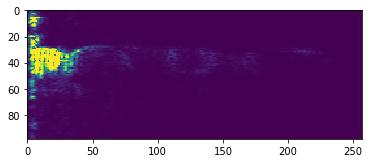

In [61]:
plt.figure()
plt.imshow(X_validation[0])

In [145]:
tmp_list = os.path.join(root_path, 'tmp_test_16words_png.txt')

In [194]:
X_test = np.empty((0,np.prod(img_dim)))
y_test = np.empty(0, dtype=int)
with open(tmp_list, 'rt') as filelist:
    #filelist = open(test_list, 'rt') 
    #X_test = np.array([np.array(Image.open(os.path.join(sound_path,fname))) for fname in filelist.read().splitlines()])
    #X_test = [np.array(Image.open(os.path.join(sound_path,fname))).reshape(np.prod(img_dim), 1) 
    idx = 0
    for fname in filelist.read().splitlines():
        idx += 1
        img = np.array(Image.open(os.path.join(sound_path,fname)))
        if img.shape == img_dim:
            X_test = np.append(X_test, img.reshape(1,-1), axis=0)  
            
            y_test = np.append(y_test, \
               [i for i in range(len(list_words)) if os.path.split(fname)[0] == list_words[i]])
            
        if idx % 100 == 0:    
            print(idx)

In [195]:
y_test

array([ 7, 10])

In [173]:
list_words = ['zero','one','two','three','four','five','six','seven','eight','nine',
              'bed','bird','cat','dog','house','tree']
print(list_words)

['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'bed', 'bird', 'cat', 'dog', 'house', 'tree']


In [181]:
os.path.split(fname)[0] == list_words[5]

True

In [186]:
[i for i in range(len(list_words)) if os.path.split(fname)[0] == list_words[i]]

[5]

In [170]:
X_test.shape

(2, 25443)

In [160]:
X_val = np.empty((len(X_validation), np.prod(img_dim)))
cnt = 0
for idx in range(len(X_validation)):
    img = X_validation[idx]
    if img.shape == img_dim:
        X_val = np.append(X_val, img.reshape(1,-1), axis=0)
        cnt += 1
    if idx % 100 == 0:
        print(idx)
    

0
100
200
300
400
500


KeyboardInterrupt: 

In [156]:
type(X_validation.shape)

tuple

In [133]:
cnt = 0
for idx in range(len(X_train)):
    if X_train[idx].shape != img_dim: 
        cnt += 1
        print(idx) 
print("cnt={}".format(cnt))

1
5
11
14
18
20
24
32
35
52
59
70
80
89
92
106
108
109
119
122
123
131
144
153
157
158
170
171
172
173
187
208
212
213
228
229
231
244
246
247
248
249
252
273
274
276
277
278
283
284
295
311
314
316
318
330
331
350
354
402
403
406
413
415
418
419
420
431
432
433
455
456
460
461
462
469
471
478
479
484
485
511
515
528
534
535
560
561
580
584
590
596
597
606
611
612
613
615
616
638
655
665
676
689
692
727
743
744
751
768
769
770
771
782
786
791
792
793
795
806
807
809
810
825
831
832
833
837
838
852
853
854
862
872
875
876
879
882
883
884
891
892
893
897
899
907
915
921
931
932
938
939
940
951
952
953
963
973
974
997
1011
1012
1020
1023
1034
1046
1056
1062
1066
1072
1084
1091
1094
1099
1103
1104
1141
1142
1148
1154
1163
1175
1176
1179
1212
1215
1216
1222
1223
1227
1228
1232
1236
1239
1240
1242
1253
1255
1265
1274
1281
1282
1283
1286
1287
1290
1291
1297
1304
1306
1316
1318
1319
1324
1325
1327
1331
1336
1338
1354
1356
1359
1361
1366
1367
1375
1385
1392
1395
1402
1406
1407
1408
1417
1423
14

35119
35172
35173
35175
35176
35182
35183
35184
35185
35186
35187
35194
35195
35219
35220
35221
35238
35243
35244
35245
35248
35289
35341
35354
35411
35413
35414
35434
35448
35449
35466
35472
35475
35476
35478
35488
35490
35502
35503
35510
35535
35543
35544
35545
35546
35547
35561
35562
35573
35574
35584
35586
35587
35592
35608
35629
35630
35649
35650
35651
35652
35653
35683
35684
35687
35716
35717
35732
35775
35805
35821
35823
35824
35825
35826
35829
35838
35839
35840
35843
35844
35850
35852
35856
35868
35873
35916
35951
36042
36043
36051
36060
36080
36081
36093
36098
36100
36101
36127
36157
36185
36186
36197
36210
36220
36223
36226
36255
36256
36257
36273
36274
36285
36289
36292
36321
36322
36323
36347
36363
36400
36406
36409
36425
36426
36433
36434
36436
36500
36501
36536
36561
36566
36575
36576
36578
36579
36592
36612
36614
36620
36622
36623
36633
36638
36639
36660
36669
36679
36681
36687
36688
36689
36691
36711
36712
36723
36724
36725
36726
36733
36750
36762
36768
36788
36792
3692

In [112]:
514640/5297

97.15688125353974

In [96]:
np.prod(img_dim)

27225

In [102]:
X_test[0].shape

AttributeError: 'list' object has no attribute 'shape'

In [98]:
img = X_validation[0]
print('{}, {}'.format(img.shape, X_validation.shape))
X = []
X = X.append(img.flatten())
type(X)

AttributeError: 'list' object has no attribute 'shape'

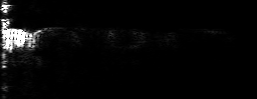

In [52]:
#Image.open('/data/01_experiment_data/img_snd/four/f34e6f44_nohash_0.png')
Image.open('/data/01_experiment_data/img_snd/dog/471a0925_nohash_0.png')
#Image.open('/data/01_experiment_data/img_snd/cat/30276d03_nohash_0.png')
#Image.open('/data/01_experiment_data/img_snd/cat/00f0204f_nohash_0.png')

We need a fuNction for iterating through mini-batches of data as follows:

In [7]:
def batch_generator(X, y, batch_size=64, 
                    shuffle=False, random_seed=None):
    
    idx = np.arange(y.shape[0])
    
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]
    
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])

* this function returns a generator with a tuple for a match of samples
    * data $X$ and lables $y$

Then, we need to normalize the data (mean centering and division by the standard deviation) for better training performance and convergence.
* compute standard deviation from the `X_train` array using `np.std` without specifying an `axis` argument 

In [8]:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_valid_centered = (X_valid - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_data, y_data, X_train, X_valid, X_test

## Implementing a CNN in TensorFlow low-level API

To implement a CNN in a TF, first we define two wrapper functions to make the process of building the network simpler.
* a wrapper function for convolutional layer
* a wrapper function for a fully connected layer

First, a convolution layer is as follows:

In [9]:
import tensorflow as tf
import numpy as np


## wrapper functions 

def conv_layer(input_tensor, name,
               kernel_size, n_output_channels, 
               padding_mode='SAME', strides=(1, 1, 1, 1)):
    with tf.variable_scope(name):
        ## get n_input_channels:
        ##   input tensor shape: 
        ##   [batch x width x height x channels_in]
        input_shape = input_tensor.get_shape().as_list()
        n_input_channels = input_shape[-1] 

        weights_shape = (list(kernel_size) + 
                         [n_input_channels, n_output_channels])

        weights = tf.get_variable(name='_weights',
                                  shape=weights_shape)
        print(weights)
        biases = tf.get_variable(name='_biases',
                                 initializer=tf.zeros(
                                     shape=[n_output_channels]))
        print(biases)
        conv = tf.nn.conv2d(input=input_tensor, 
                            filter=weights,
                            strides=strides, 
                            padding=padding_mode)
        print(conv)
        conv = tf.nn.bias_add(conv, biases, 
                              name='net_pre-activation')
        print(conv)
        conv = tf.nn.relu(conv, name='activation')
        print(conv)
        
        return conv
    

## testing
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
    conv_layer(x, name='convtest', kernel_size=(3, 3), n_output_channels=32)
    
del g, x

<tf.Variable 'convtest/_weights:0' shape=(3, 3, 1, 32) dtype=float32_ref>
<tf.Variable 'convtest/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("convtest/Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("convtest/net_pre-activation:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("convtest/activation:0", shape=(?, 28, 28, 32), dtype=float32)


* defining the weights, biases, initializing them, and the convolution operation using the `tf.nn.conv2d` function with the following required arguments
    * `input_tensor`: the tensor given as input to the convolutional layer
    * `name`: the name of the layer, which is used as the scope name
    * `kernel_size`: the dimensions of the kernel tensor provided as a tuple or list
    * `n_output_channels`: the number of output feature maps
* this function was tested with a simple input by defining a placeholder

<br>

The next wrapper function is for defining the fully connected layers:


In [10]:
def fc_layer(input_tensor, name, 
             n_output_units, activation_fn=None):
    with tf.variable_scope(name):
        input_shape = input_tensor.get_shape().as_list()[1:]
        n_input_units = np.prod(input_shape)
        if len(input_shape) > 1:
            input_tensor = tf.reshape(input_tensor, 
                                      shape=(-1, n_input_units))

        weights_shape = [n_input_units, n_output_units]

        weights = tf.get_variable(name='_weights',
                                  shape=weights_shape)
        print(weights)
        biases = tf.get_variable(name='_biases',
                                 initializer=tf.zeros(
                                     shape=[n_output_units]))
        print(biases)
        layer = tf.matmul(input_tensor, weights)
        print(layer)
        layer = tf.nn.bias_add(layer, biases,
                              name='net_pre-activation')
        print(layer)
        if activation_fn is None:
            return layer
        
        layer = activation_fn(layer, name='activation')
        print(layer)
        return layer

    
## testing:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32, 
                       shape=[None, 28, 28, 1])
    fc_layer(x, name='fctest', n_output_units=32, 
             activation_fn=tf.nn.relu)
    
del g, x

<tf.Variable 'fctest/_weights:0' shape=(784, 32) dtype=float32_ref>
<tf.Variable 'fctest/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("fctest/MatMul:0", shape=(?, 32), dtype=float32)
Tensor("fctest/net_pre-activation:0", shape=(?, 32), dtype=float32)
Tensor("fctest/activation:0", shape=(?, 32), dtype=float32)


In [11]:
g2 = tf.Graph()
with g2.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
    fc_layer1 = fc_layer(x, name='fc1', n_output_units=1024, activation_fn=tf.nn.relu)
    fc_layer2 = fc_layer(fc_layer1, name='fc2', n_output_units=10, activation_fn=tf.nn.sigmoid)
    
del g2, x

<tf.Variable 'fc1/_weights:0' shape=(784, 1024) dtype=float32_ref>
<tf.Variable 'fc1/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc1/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc1/net_pre-activation:0", shape=(?, 1024), dtype=float32)
Tensor("fc1/activation:0", shape=(?, 1024), dtype=float32)
<tf.Variable 'fc2/_weights:0' shape=(1024, 10) dtype=float32_ref>
<tf.Variable 'fc2/_biases:0' shape=(10,) dtype=float32_ref>
Tensor("fc2/MatMul:0", shape=(?, 10), dtype=float32)
Tensor("fc2/net_pre-activation:0", shape=(?, 10), dtype=float32)
Tensor("fc2/activation:0", shape=(?, 10), dtype=float32)


* builds the weights and biases, initializes them similar to the `conv_layer` function, and then perform a matrix multiplication using the `tf.matmul` function
* the requied arguments are
    * `input_tensor`: the input tensor
    * `name`: the name of the layer, a scope name
    * `n_output_units`: the number of output units
* the `fc_layer` function was tested for a simple input tensor 

<br>

Now, we can utilize these wrapper functions to build the whole convolutional network.
* define a function called `build_cnn` to handle the building of the CNN model as follows:


In [12]:
def build_cnn():
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, 784],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor: 
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, 28, 28, 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=10,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    h1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5), 
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling
    h1_pool = tf.nn.max_pool(h1, 
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], 
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    h2 = conv_layer(h1_pool, name='conv_2', 
                    kernel_size=(5,5), 
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling 
    h2_pool = tf.nn.max_pool(h2, 
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1], 
                             padding='SAME')

    ## 3rd layer: Fully Connected
    print('\nBuilding 3rd layer:')
    h3 = fc_layer(h2_pool, name='fc_3',
                  n_output_units=1024, 
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    h3_drop = tf.nn.dropout(h3, keep_prob=keep_prob, 
                            name='dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    h4 = fc_layer(h3_drop, name='fc_4',
                  n_output_units=10, 
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities' : tf.nn.softmax(h4, name='probabilities'),
        'labels' : tf.cast(tf.argmax(h4, axis=1), tf.int32,
                           name='labels')
    }
    
    ## Visualize the graph with TensorBoard:

    ## Loss Function and Optimization
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits=h4, labels=tf_y_onehot),
        name='cross_entropy_loss')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss,
                                   name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'], 
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')

    
def save(saver, sess, epoch, path='./model/'):
    if not os.path.isdir(path):
        os.makedirs(path)
    print('Saving model in %s' % path)
    saver.save(sess, os.path.join(path,'cnn-model.ckpt'),
               global_step=epoch)

    
def load(saver, sess, path, epoch):
    print('Loading model from %s' % path)
    saver.restore(sess, os.path.join(
            path, 'cnn-model.ckpt-%d' % epoch))

    
def train(sess, training_set, validation_set=None,
          initialize=True, epochs=20, shuffle=True,
          dropout=0.5, random_seed=None):

    X_data = np.array(training_set[0])
    y_data = np.array(training_set[1])
    training_loss = []

    ## initialize variables
    if initialize:
        sess.run(tf.global_variables_initializer())

    np.random.seed(random_seed) # for shuflling in batch_generator
    for epoch in range(1, epochs+1):
        batch_gen = batch_generator(
                        X_data, y_data, 
                        shuffle=shuffle)
        avg_loss = 0.0
        for i,(batch_x,batch_y) in enumerate(batch_gen):
            feed = {'tf_x:0': batch_x, 
                    'tf_y:0': batch_y, 
                    'fc_keep_prob:0': dropout}
            loss, _ = sess.run(
                    ['cross_entropy_loss:0', 'train_op'],
                    feed_dict=feed)
            avg_loss += loss

        training_loss.append(avg_loss / (i+1))
        print('Epoch %02d Training Avg. Loss: %7.3f' % (
            epoch, avg_loss), end=' ')
        if validation_set is not None:
            feed = {'tf_x:0': validation_set[0],
                    'tf_y:0': validation_set[1],
                    'fc_keep_prob:0':1.0}
            valid_acc = sess.run('accuracy:0', feed_dict=feed)
            print(' Validation Acc: %7.3f' % valid_acc)
        else:
            print()

            
def predict(sess, X_test, return_proba=False):
    feed = {'tf_x:0': X_test, 
            'fc_keep_prob:0': 1.0}
    if return_proba:
        return sess.run('probabilities:0', feed_dict=feed)
    else:
        return sess.run('labels:0', feed_dict=feed)

* the following figure shows the TF graph related to our multilayer CNN as visualized by TensorBoard:
<img src='images/15_10.png' width=800> 
* also, defined four other functions
    * `save`, `load`, `train` for training the model using `training_set`, and `predict` to get prediction probabilities or prediction labels of the test data

Now, we can create a TF graph object, set the graph-level random seed, and build the CNN model in that graph as follows:

In [13]:
import tensorflow as tf
import numpy as np

## Define hyperparameters
learning_rate = 1e-4
random_seed = 123

np.random.seed(random_seed)


## create a graph
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
    build_cnn()

    ## saver:
    saver = tf.train.Saver()


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

Next step is to train our CNN model.
* need to create a TF session to launch the graph
    * then, call the `train` function
    * to train the model for the first time, need to initialize all the variables in the network
        * `initialize` argument to `True` will execute `tf.global_variables_initializer` through `session.run`
            * this initialization step should be avoided in case you want to train additional epochs (e.g., restoring an already trained model and train further for additional epochs)


In [14]:
## crearte a TF session 
## and train the CNN model

with tf.Session(graph=g) as sess:
    train(sess, 
          training_set=(X_train_centered, y_train), 
          validation_set=(X_valid_centered, y_valid), 
          initialize=True,
          random_seed=123, epochs=3)
    save(saver, sess, epoch=3)

Epoch 01 Training Avg. Loss: 272.307  Validation Acc:   0.972
Epoch 02 Training Avg. Loss:  75.711  Validation Acc:   0.982
Epoch 03 Training Avg. Loss:  51.187  Validation Acc:   0.985
Saving model in ./model/


* after the 20 epochs, the trained model was saved for future use
* the following code shows how to restore a saved model
    * delte the graph `g`, then create a new graph `g2`, and reload the trained model to do prediction on the test set:

In [15]:
### Calculate prediction accuracy
### on test set
### restoring the saved model

del g

## create a new graph 
## and build the model
g2 = tf.Graph()
with g2.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
    build_cnn()

    ## saver:
    saver = tf.train.Saver()

## create a new session 
## and restore the model
with tf.Session(graph=g2) as sess:
    load(saver, sess, 
         epoch=3, path='./model/')
    
    preds = predict(sess, X_test_centered, 
                    return_proba=False)

    print('Test Accuracy: %.3f%%' % (100*
                np.sum(preds == y_test)/len(y_test)))
    


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

* the prediction accuracy on the test set is already better than what we obtained using multilayer perceptron in Chapter 13
* `X_test_centered` as test data not `X_test` 
* now, let's look at the predicted labels as well as their probabilities on the first 10 test samples


In [16]:
## run the prediction on 
##  some test samples

np.set_printoptions(precision=2, suppress=True)

with tf.Session(graph=g2) as sess:
    load(saver, sess, 
         epoch=20, path='./model/')
        
    print(predict(sess, X_test_centered[:10], 
              return_proba=False))
    
    print(predict(sess, X_test_centered[:10], 
                  return_proba=True))

Loading model from ./model/
INFO:tensorflow:Restoring parameters from ./model/cnn-model.ckpt-20
[7 2 1 0 4 1 4 9 5 9]
[[ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.99  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.99]
 [ 0.    0.    0.    0.    0.    0.99  0.01  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]]


Finally, let's see how we can train the model further to reach a total of 40 epochs.
* restoring the already trained model and continue training for 20 additional epochs
    * call the `train` function again with `initialize = False` to avoid the initialization step


In [17]:
## continue training for 20 more epochs
## without re-initializing :: initialize=False
## create a new session 
## and restore the model
with tf.Session(graph=g2) as sess:
    load(saver, sess, 
         epoch=3, path='./model/')
    
    train(sess,
          training_set=(X_train_centered, y_train), 
          validation_set=(X_valid_centered, y_valid),
          initialize=False,
          epochs=3,
          random_seed=123)
        
    save(saver, sess, epoch=6, path='./model/')
    
    preds = predict(sess, X_test_centered, 
                    return_proba=False)
    
    print('Test Accuracy: %.3f%%' % (100*
                np.sum(preds == y_test)/len(y_test)))

Loading model from ./model/
INFO:tensorflow:Restoring parameters from ./model/cnn-model.ckpt-3
Epoch 01 Training Avg. Loss:  40.560  Validation Acc:   0.986
Epoch 02 Training Avg. Loss:  32.581  Validation Acc:   0.988
Epoch 03 Training Avg. Loss:  27.416  Validation Acc:   0.988
Saving model in ./model/
Test Accuracy: 99.100%


* the result shows that training for 20 additional epochs slightly improved the performance to get 99.37% prediction accuracy on the test set

In the next section, we'll now implement the CNN using the TF Layers API.


## Implementing a CNN in the TensorFlow Layers API

We can implement the model in a new class as follows:

In [18]:
import tensorflow as tf
import numpy as np


class ConvNN(object):
    def __init__(self, batchsize=64,
                 epochs=20, learning_rate=1e-4, 
                 dropout_rate=0.5,
                 shuffle=True, random_seed=None):
        np.random.seed(random_seed)
        self.batchsize = batchsize
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.shuffle = shuffle
                
        g = tf.Graph()
        with g.as_default():
            ## set random-seed:
            tf.set_random_seed(random_seed)
            
            ## build the network:
            self.build()

            ## initializer
            self.init_op = \
                tf.global_variables_initializer()

            ## saver
            self.saver = tf.train.Saver()
            
        ## create a session
        self.sess = tf.Session(graph=g)
                
    def build(self):
        
        ## Placeholders for X and y:
        tf_x = tf.placeholder(tf.float32, 
                              shape=[None, 784],
                              name='tf_x')
        tf_y = tf.placeholder(tf.int32, 
                              shape=[None],
                              name='tf_y')
        is_train = tf.placeholder(tf.bool, 
                              shape=(),
                              name='is_train')

        ## reshape x to a 4D tensor: 
        ##  [batchsize, width, height, 1]
        tf_x_image = tf.reshape(tf_x, shape=[-1, 28, 28, 1],
                              name='input_x_2dimages')
        ## One-hot encoding:
        tf_y_onehot = tf.one_hot(indices=tf_y, depth=10,
                              dtype=tf.float32,
                              name='input_y_onehot')

        ## 1st layer: Conv_1
        h1 = tf.layers.conv2d(tf_x_image, 
                              kernel_size=(5, 5), 
                              filters=32, 
                              activation=tf.nn.relu)
        ## MaxPooling
        h1_pool = tf.layers.max_pooling2d(h1, 
                              pool_size=(2, 2), 
                              strides=(2, 2))
        ## 2n layer: Conv_2
        h2 = tf.layers.conv2d(h1_pool, kernel_size=(5,5), 
                              filters=64, 
                              activation=tf.nn.relu)
        ## MaxPooling 
        h2_pool = tf.layers.max_pooling2d(h2, 
                              pool_size=(2, 2), 
                              strides=(2, 2))

        ## 3rd layer: Fully Connected
        input_shape = h2_pool.get_shape().as_list()
        n_input_units = np.prod(input_shape[1:])
        h2_pool_flat = tf.reshape(h2_pool, 
                              shape=[-1, n_input_units])
        h3 = tf.layers.dense(h2_pool_flat, 1024, 
                              activation=tf.nn.relu)

        ## Dropout
        h3_drop = tf.layers.dropout(h3, 
                              rate=self.dropout_rate,
                              training=is_train)
        
        ## 4th layer: Fully Connected (linear activation)
        h4 = tf.layers.dense(h3_drop, 10, 
                              activation=None)

        ## Prediction
        predictions = {
            'probabilities': tf.nn.softmax(h4, 
                              name='probabilities'),
            'labels': tf.cast(tf.argmax(h4, axis=1), 
                              tf.int32, name='labels')}
        
        ## Loss Function and Optimization
        cross_entropy_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=h4, labels=tf_y_onehot),
            name='cross_entropy_loss')
        
        ## Optimizer:
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss,
                              name='train_op')

        ## Finding accuracy
        correct_predictions = tf.equal(
            predictions['labels'], 
            tf_y, name='correct_preds')
        
        accuracy = tf.reduce_mean(
            tf.cast(correct_predictions, tf.float32),
            name='accuracy')

    def save(self, epoch, path='./tflayers-model/'):
        if not os.path.isdir(path):
            os.makedirs(path)
        print('Saving model in %s' % path)
        self.saver.save(self.sess, 
                        os.path.join(path, 'model.ckpt'),
                        global_step=epoch)
        
    def load(self, epoch, path):
        print('Loading model from %s' % path)
        self.saver.restore(self.sess, 
             os.path.join(path, 'model.ckpt-%d' % epoch))
        
    def train(self, training_set, 
              validation_set=None,
              initialize=True):
        ## initialize variables
        if initialize:
            self.sess.run(self.init_op)

        self.train_cost_ = []
        X_data = np.array(training_set[0])
        y_data = np.array(training_set[1])

        for epoch in range(1, self.epochs + 1):
            batch_gen = \
                batch_generator(X_data, y_data, 
                                 shuffle=self.shuffle)
            avg_loss = 0.0
            for i, (batch_x,batch_y) in \
                enumerate(batch_gen):
                feed = {'tf_x:0': batch_x, 
                        'tf_y:0': batch_y,
                        'is_train:0': True} ## for dropout
                loss, _ = self.sess.run(
                        ['cross_entropy_loss:0', 'train_op'], 
                        feed_dict=feed)
                avg_loss += loss
                
            print('Epoch %02d: Training Avg. Loss: '
                  '%7.3f' % (epoch, avg_loss), end=' ')
            if validation_set is not None:
                feed = {'tf_x:0': batch_x, 
                        'tf_y:0': batch_y,
                        'is_train:0': False} ## for dropout
                valid_acc = self.sess.run('accuracy:0',
                                          feed_dict=feed)
                print('Validation Acc: %7.3f' % valid_acc)
            else:
                print()
                    
    def predict(self, X_test, return_proba = False):
        feed = {'tf_x:0': X_test,
                'is_train:0': False} ## for dropout
        if return_proba:
            return self.sess.run('probabilities:0',
                                 feed_dict=feed)
        else:
            return self.sess.run('labels:0',
                                 feed_dict=feed)




* the structure of this class is very similar to the previous section with the low-level TF API
    * the class has a constructor that sets the training parameters, creates a graph `g`, and builds the model
    * besides the constructor, there are five major methods 
        * `.build`: builds the model
        * `.save`: to save a trained model
        * `.load`: to restore a saved model
        * `.train`: trains the model
        * `.predict`: to do prediction on a test set
* a dropout layer after the first fully connected layer (`tf.nn.dropout` in low-level API and `tf.layers.dropout` in the high-level Layers API)
    * `tf.nn.dropout`: :an argument, `keep_prob` indicates the probability of keeping the units, whereas `tf.layers.dropout` has a `rate` parameter, which is the rate of dropping units (i.e., `rate = 1 - keep_prob`)
    * in the `tf.nn.dropout` function, we fed the `keep_prob` parameter using a placeholder
        * during the training, `keep_prob = 0.5`
        * during the inference (or prediction), `keep_prob = 1`
    * in the `tf.layers.dropout`, the value `rate` is provided upon the creation of the dropout layer in the graph
        * we cannot change it during the training or the inference modes
            * instead, a Boolean argument called `training` to determine whether we need to apply dropout or not (`tf.bool=True` during the training mode and `tf.bool=False` during the inference mode)
            

We can create an instance of the `ConvNN` class, train it for 20 epochs, and save the model as follows:

In [19]:
cnn = ConvNN(random_seed=123, epochs=3)
cnn.train(training_set=(X_train_centered, y_train), 
          validation_set=(X_valid_centered, y_valid))

#cnn.save(epoch=20)
cnn.save(epoch=3)

Epoch 01: Training Avg. Loss: 269.172 Validation Acc:   1.000
Epoch 02: Training Avg. Loss:  74.298 Validation Acc:   0.938
Epoch 03: Training Avg. Loss:  50.655 Validation Acc:   1.000
Saving model in ./tflayers-model/


* after the training is finished, the model can be used to do prediction on the test dataset:

In [20]:
del cnn

cnn2 = ConvNN(random_seed=123)

#cnn2.load(epoch=20, path='./tflayers-model/')
cnn2.load(epoch=3, path='./tflayers-model/')

print(cnn2.predict(X_test_centered[:10,:]))

Loading model from ./tflayers-model/
INFO:tensorflow:Restoring parameters from ./tflayers-model/model.ckpt-3
[7 2 1 0 4 1 4 9 5 9]


Finally, we can measure the accuracy of the test dataset as follows:

In [21]:
preds = cnn2.predict(X_test_centered)

print('Test Accuracy: %.2f%%' % (100*
      np.sum(y_test == preds)/len(y_test)))

Test Accuracy: 98.76%


* the obtained accuracy is 98.76%, which means there are 124 misclassified test samples


# Summary


In this chapter, we learned about CNNs and explored the building blocks that form different CNN architectures.
* started by defining the convolution operation
* covered subsampling by discussing two forms of pooling operations
    * max-pooling 
    * average-pooling

Then, putting all these blocks together, a deep CNN was built using the TF core API as well as TF __Layers__ API for image classification.

In the next chapter, we'll move on to __Recurrent Neural Networks (RNN)__.
* used for learning the structure of sequence data 
* applications including language translation and image captioning
